In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as tsaplots
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
import matplotlib.dates as mdates


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DXG Historical Data.csv')

In [ ]:
# Checking null value
df.isnull().sum()

Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64

In [ ]:
df.dtypes

Date        object
Price       object
Open        object
High        object
Low         object
Vol.        object
Change %    object
dtype: object

In [ ]:
# convert date field from string to Date format and make it index
def tranformData(df: pd.DataFrame):
  df['Date'] = pd.to_datetime(df.Date, format='%m/%d/%Y')
  df['Price'] = df['Price'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['Open'] = df['Open'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['High'] = df['High'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['Low'] = df['Low'].astype(str).apply(lambda x: float(x.replace(',', '')))
  def convert_to_number(x):
      if 'M' in x:
          return float(x.replace('M', '')) * 1000000
      elif 'K' in x:
          return float(x.replace('K', '')) * 1000
      else:
          return float(x)
  df['Vol.'] = df['Vol.'].apply(convert_to_number)
  df['Change %'] = df['Change %'].apply(lambda x: float(x.strip('%'))/100)

In [ ]:
tranformData(df)
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2023-06-02,15150.0,15400.0,15500.0,15000.0,20980000.0,0.0000
1,2023-06-01,15150.0,14900.0,15200.0,14850.0,18460000.0,0.0168
2,2023-05-31,14900.0,14950.0,15200.0,14850.0,15100000.0,-0.0033
3,2023-05-30,14950.0,14950.0,15200.0,14750.0,30200000.0,0.0240
4,2023-05-29,14600.0,14650.0,14750.0,14500.0,13240000.0,0.0104
...,...,...,...,...,...,...,...
1366,2017-12-07,12100.6,12161.1,12312.3,11858.5,5230000.0,-0.0050
1367,2017-12-06,12161.1,12161.1,12342.6,11919.0,7720000.0,-0.0099
1368,2017-12-05,12282.1,12705.6,12917.3,12282.1,11060000.0,-0.0333
1369,2017-12-04,12705.6,12463.6,12705.6,12282.1,9420000.0,0.0370


In [ ]:
df=df.set_index('Date')
df = df.sort_index()
df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2017-12-01,12251.8,11949.3,12403.1,11919.0,8610000.0,0.0279
2017-12-04,12705.6,12463.6,12705.6,12282.1,9420000.0,0.0370
2017-12-05,12282.1,12705.6,12917.3,12282.1,11060000.0,-0.0333
2017-12-06,12161.1,12161.1,12342.6,11919.0,7720000.0,-0.0099
2017-12-07,12100.6,12161.1,12312.3,11858.5,5230000.0,-0.0050
...,...,...,...,...,...,...
2023-05-29,14600.0,14650.0,14750.0,14500.0,13240000.0,0.0104
2023-05-30,14950.0,14950.0,15200.0,14750.0,30200000.0,0.0240
2023-05-31,14900.0,14950.0,15200.0,14850.0,15100000.0,-0.0033


In [ ]:
fig = px.line(df, x=df.index, y=df.Price,labels={'Date':'Date','Price':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.6)
fig.update_layout(title_text='Stock close price for chart of HSG', plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [ ]:
def prepare_data_for_gan(df, num_steps):
    data = df.values
    data = data.reshape(-1, 1)  # Chuyển đổi dữ liệu thành ma trận 2D (số mẫu, 1)
    
    # Chuẩn hóa dữ liệu về khoảng [0, 1]
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data)
    
    # Chia dữ liệu thành các chuỗi con có độ dài num_steps
    X = []
    for i in range(len(data) - num_steps):
        X.append(data[i:i+num_steps])
    
    # Chuyển đổi thành numpy array
    X = np.array(X)
    
    # Tính số lượng mẫu trong tập huấn luyện, tập kiểm tra
    train_size = int(len(df) * 0.7)
    test_size = int(0.2 * len(df))
    val_size = len(df) - train_size - test_size


    train_data = data[:train_size]
    test_data = data[train_size:train_size+test_size]
    val_data = data[train_size+test_size:]

    return train_data, test_data, val_data, scaler


In [ ]:
# Số lượng bước thời gian trong mỗi chuỗi con
num_steps = 5

# Chuẩn bị dữ liệu cho mô hình Time-GAN
train_data, test_data, val_data, scaler = prepare_data_for_gan(df['Price'], num_steps)

# In số lượng mẫu trong mỗi tập dữ liệu
print("Số lượng mẫu trong tập huấn luyện:", train_data.shape)
print("Số lượng mẫu trong tập kiểm tra:", test_data.shape)
print("Số lượng mẫu trong tập valid: ", val_data.shape)

Số lượng mẫu trong tập huấn luyện: (959, 1)
Số lượng mẫu trong tập kiểm tra: (274, 1)
Số lượng mẫu trong tập valid:  (138, 1)


In [ ]:
def build_time_gan(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    
    return model

# Xác định input_shape
input_shape = (num_steps, 1)

# Xây dựng mô hình Time-GAN
model = build_time_gan(input_shape)

# In thông tin về mô hình
model.summary()


Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_39 (Bidirecti  (None, 5, 128)           33792     
 onal)                                                           
                                                                 
 dropout_39 (Dropout)        (None, 5, 128)            0         
                                                                 
 bidirectional_40 (Bidirecti  (None, 5, 128)           98816     
 onal)                                                           
                                                                 
 dropout_40 (Dropout)        (None, 5, 128)            0         
                                                                 
 bidirectional_41 (Bidirecti  (None, 128)              98816     
 onal)                                                           
                                                     

In [ ]:
def train_time_gan(model, train_data, epochs, num_steps):
    X_train = []
    y_train = []
    for i in range(len(train_data) - num_steps):
        X_train.append(train_data[i:i+num_steps])
        y_train.append(train_data[i+num_steps])
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    model.compile(optimizer='adam', loss='mean_squared_error')
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=1)
    return history



# Số lượng time steps
epochs = 10

# Huấn luyện mô hình Time-GAN
history = train_time_gan(model, train_data, epochs, num_steps)


Epoch 1/10
30/30 [==============================] - 13s 16ms/step - loss: 0.0087
Epoch 2/10
30/30 [==============================] - 1s 17ms/step - loss: 7.5436e-04
Epoch 3/10
30/30 [==============================] - 1s 17ms/step - loss: 5.9827e-04
Epoch 4/10
30/30 [==============================] - 0s 17ms/step - loss: 5.8550e-04
Epoch 5/10
30/30 [==============================] - 1s 17ms/step - loss: 5.4221e-04
Epoch 6/10
30/30 [==============================] - 1s 17ms/step - loss: 5.7465e-04
Epoch 7/10
30/30 [==============================] - 0s 16ms/step - loss: 5.6158e-04
Epoch 8/10
30/30 [==============================] - 0s 16ms/step - loss: 5.0614e-04
Epoch 9/10
30/30 [==============================] - 0s 17ms/step - loss: 5.1524e-04
Epoch 10/10
30/30 [==============================] - 0s 12ms/step - loss: 4.9852e-04


1/1 [==============================] - 0s 22ms/step
Validation RMSE: 0.29858401260305456
Testing RMSE: 0.2294605773904677


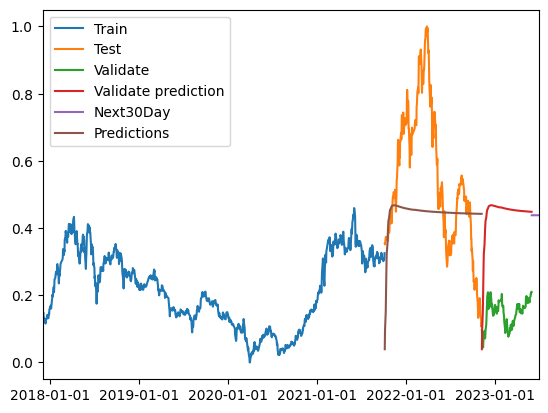

In [ ]:
# Quá trình testing
x_test = np.arange(len(test_data)).reshape(-1, 1)
y_test = np.array(test_data)
y_pred = model.predict(x_test)

# Quá trình validate
x_val = np.arange(len(val_data)).reshape(-1, 1)
y_val = np.array(val_data)
y_pred_val = model.predict(x_val)

# Quá trình validate
x_val = np.arange(len(val_data)).reshape(-1, 1)
y_val = np.array(val_data)
y_pred_val = model.predict(x_val)

# Tạo dataframe dự báo cho 30 ngày tiếp theo
last_date = pd.to_datetime(df.index[-1])
forecast_dates = pd.date_range(last_date, periods=30, freq='D')[1:]
forecast_df = pd.DataFrame({'Date': forecast_dates, 'Price': np.zeros(len(forecast_dates))})

# Dự đoán giá đóng cửa cho 30 ngày tiếp theo
x_next_30_days = np.arange(len(df), len(df) + len(forecast_df)).reshape(-1, 1)
y_next_30_days = model.predict(x_next_30_days)

# Đưa các dự đoán vào dataframe forecast_df
forecast_df['Price'] = y_next_30_days

# Tính toán RMSE cho quá trình validate và testing
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
# Convert dates to a more appropriate format
dates = pd.to_datetime(df.index)

# Vẽ biểu đồ
plt.plot(dates[:len(train_data)], train_data)
plt.plot(dates[len(train_data):len(train_data)+len(test_data)], test_data)
plt.plot(dates[len(train_data)+len(test_data):len(train_data)+len(test_data)+len(val_data)], val_data)
plt.plot(dates[len(train_data)+len(test_data):len(train_data)+len(test_data)+len(val_data)], y_pred_val)
plt.plot(forecast_df.Date, forecast_df.Price)
plt.plot(dates[len(train_data):len(train_data)+len(test_data)], y_pred)

# Set x-axis range
plt.xlim(dates[0], forecast_dates[-1])

# Set x-axis ticks
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.legend(['Train', 'Test', 'Validate', 'Validate prediction', 'Next30Day', 'Predictions'])
plt.show()
